# One shot learning siamese network for omniglot dataset
### Implementation of the following paper
Siamese Neural Networks for One-shot Image Recognition (Gregory et.al)

## Requirements


1.   Pytorch >= 0.4.0
2.   Python 3.5+

## Deep Siamese Networks for Image Verification 
Siamese  nets  were  first  introduced  in  the  early  1990s  by
Bromley and LeCun to solve signature verification as an
image matching problem. A siamese neural network consists of twin networks which accept distinct inputs but are joined by an energy function at the top. This function computes some metric between the highest-level feature representation on each side. Also, the network is symmetric, so that whenever we present two distinct images to the twin networks, the top conjoining layer will compute the same metric as if we were to we present the same two images but to the opposite twins.

The aim is to  first  learn  a  neural  network  that  can  discriminate between  the  class-identity  of  image  pairs,  which  is  the standard verification task for image recognition.  The verification model learns to identify input pairs according to the probability  that  they  belong  to  the  same  class  or  different classes.  This model can then be used to evaluate new images, exactly one per novel class, in a pairwise manner against the test image.  The pairing with the highest score according to the verification network is then awarded the highest  probability  for  the  one-shot  task.   If  the  features learned by the verification model are sufficient to confirm or deny the identity of characters from one set of alphabets,  then they ought to be sufficient for other alphabets, provided that the model has been exposed to a variety of alphabets to encourage variance amongst the learned features.
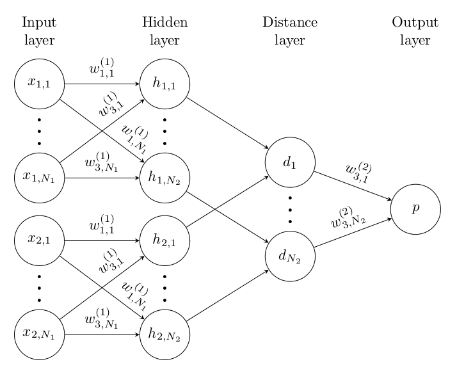

### Step1- Setting up the workspace
Download the Omniglot dataset and unzip it in the workspace (in this case workspace is 'Omniglot'). Save the data in two folders 'images_background' and 'images_evaluation' respectively. 

### Step2- Installing frameworks and impoting libraries
Importing all the libraries, dependencies and the framework required using the following commands
!pip install torch torchvision
!pip install Pillow==4.0.0
!pip install image


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from numpy.random import choice as npc
import numpy as np
import time
import random
import torchvision.datasets as dset
from PIL import Image
import pickle
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch.nn as nn
import torch.nn.functional as F

## Omniglot dataset

The Omniglot data set was collected by Brenden Lake and
his collaborators at MIT via Amazon’s Mechanical Turk to
produce a standard benchmark for learning from few examples in the handwritten character recognition domain.
Omniglot contains examples from 50 alphabets ranging from well established international languages like Latin and Korean to lesser known local dialects. The number of letters in each alphabet varies considerably
from  about  15  to  upwards  of  40  characters
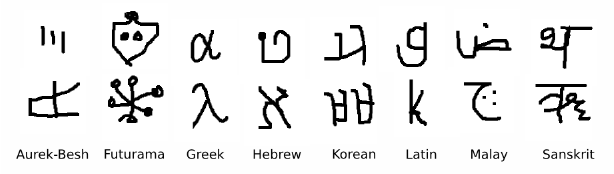

### Step3- Preprocessing training dataset
Creating a class for loading training dataset which samples two random images and gives it a label =1.0 if they belong to the same class or label= 0.0 if they belong to different class. Each pair is given a specific index.

In [ ]:
class OmniglotTrain(Dataset):

    def __init__(self, dataset, transform=None):
        super(OmniglotTrain, self).__init__()
        np.random.seed(0)
        self.dataset = dataset
        self.transform = transform
        self.img1 = None

    def __len__(self):
        return  21000000

    def __getitem__(self, index):
        image1 = random.choice(self.dataset.imgs)
        # get image from same class
        label = None
        if index % 2 == 1:
            label = 1.0
            while True:
                image2 = random.choice(self.dataset.imgs)
                if image1[1] == image2[1]:
                    break
        # get image from different class
        else:
            label = 0.0
            while True:
                image2 = random.choice(self.dataset.imgs)
                if image1[1] != image2[1]:
                    break
        image1 = Image.open(image1[0])
        image2 = Image.open(image2[0])
        image1 = image1.convert('L')
        image2 = image2.convert('L')

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, torch.from_numpy(np.array([label], dtype=np.float32))

### Step4 - Preprocessing testing data
Creating a class for loading test dataset. This class samples two random images from the test dataset and gives it a specific index. As it is a 20 way classification, one in 20 pairs belongs to the same class. Each class gets one example.

In [ ]:
class OmniglotTest(Dataset):

    def __init__(self, dataset, transform=None, times=200, way=20):
        np.random.seed(1)
        super(OmniglotTest, self).__init__()
        self.dataset = dataset
        self.transform = transform
        self.times = times
        self.way = way

    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        idx = index % self.way
        label = None
        # generate image pair from same class
        if idx == 0:
            self.img1 = random.choice(self.dataset.imgs)
            while True:
                img2 = random.choice(self.dataset.imgs)
                if self.img1[1] == img2[1]:
                    break
        # generate image pair from different class
        else:
            while True:
                img2 = random.choice(self.dataset.imgs)
                if self.img1[1] != img2[1]:
                    break

        img1 = Image.open(self.img1[0])
        img2 = Image.open(img2[0])
        img1 = img1.convert('L')
        img2 = img2.convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1, img2


### Step 5- Model

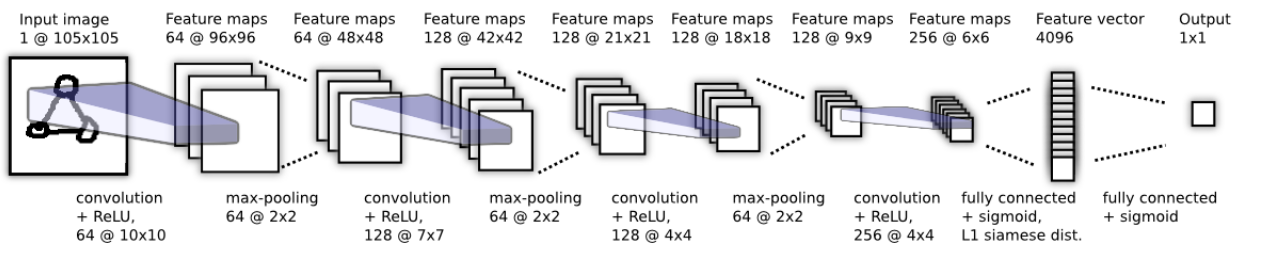

The model consists of a sequence of convolutional layers, each of which uses a single channel with filters of varying
size and a fixed stride of 1.  The number of convolutional filters is specified as a multiple of 16 to optimize performance.   The network applies a ReLU activation function to  the  output  feature  maps,  optionally  followed  by  max-pooling with a filter size and stride of 2.

The units in the final convolutional layer are flattened into a  single  vector.   This  convolutional  layer  is  followed  by a  fully-connected  layer,  and  then  one  more  layer  computing the induced distance metric between each siamese twin,  which  is  given  to  a  single  sigmoidal  output  unit.


In [ ]:
class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        #  return self.sigmoid(out)
        return out

### Step 6- GPU check
check whether CUDA is working

In [ ]:
cuda = torch.cuda.is_available()
print("Cuda: " + str(cuda))          #Checking if CUDA is available

### Step 7- Affine distortions
Augmenting the training set with small affine distortions.  For each
image  pair
x1, x2,  we  generated  a  pair  of  affine  transformations T1, T2 to  yield x′1= T1(x1), x′2=T2(x2), where T1, T2 are determined  stochastically  by  a  multi-dimensional uniform distribution. 
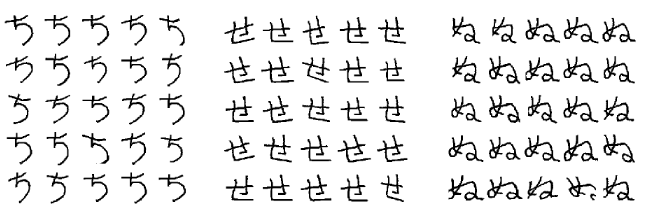

In [ ]:
data_transforms = transforms.Compose([
    transforms.RandomAffine(15),
    transforms.ToTensor()
])

### Step 8- Setting up the path for loading training and testing dataset

In [ ]:
train_path = 'training'
test_path = 'evaluation'
train_dataset = dset.ImageFolder(root=train_path)
test_dataset = dset.ImageFolder(root=test_path)

### Step 9- Loading the data and creating pairs for training and testing with Affine distortions

In [ ]:
way = 20
times = 400

dataSet = OmniglotTrain(train_dataset, transform=data_transforms)
testSet = OmniglotTest(test_dataset, transform=transforms.ToTensor(), times = times, way = way)
testLoader = DataLoader(testSet, batch_size=way, shuffle=False, num_workers=16)

dataLoader = DataLoader(dataSet, batch_size=128,\
                        shuffle=False, num_workers=16)

### Step 10- Loss function

A regularized cross-entropy objective on our binary classifier

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss(size_average=True)
learning_rate = 0.0006
net = Siamese()
train_loss = []
net.train()
if cuda:
    net.cuda()

### Step 11- Optimizer
Used a standarised Adam optimizer

In [ ]:
optimizer = torch.optim.Adam(net.parameters(),lr = learning_rate )
optimizer.zero_grad()

### Step 12- Setting up the parameters

In [ ]:
show_every = 10
save_every = 100
test_every = 100
train_loss = []
loss_val = 0
max_iter = 90000
losses=[]
batch_ids= []

### Step 13- Training and testing after every 100 batch size

In [ ]:
for batch_id, (img1, img2, label) in enumerate(dataLoader, 1):
    if batch_id > max_iter:
        break
    batch_start = time.time()
    if cuda:
        img1, img2, label = Variable(img1.cuda()), Variable(img2.cuda()), Variable(label.cuda())
    else:
        img1, img2, label = Variable(img1), Variable(img2), Variable(label)
    optimizer.zero_grad()
    output = net.forward(img1, img2)
    loss = loss_fn(output, label)
    loss_val += loss.item()
    loss.backward()
    optimizer.step()
    if batch_id % show_every == 0 :
        print('[%d]\tloss:\t%.5f\tTook\t%.2f s'%(batch_id, loss_val/show_every, (time.time() - batch_start)*show_every))
        batch_ids.append(float(batch_id))
        losses.append(loss_val/show_every)
        loss_val = 0
    if batch_id % save_every == 0:
        torch.save(net.state_dict(), 'model/model-batch-%d.pth'%(batch_id+1,))
    if batch_id % test_every == 0:
        right, error = 0, 0
        for _, (test1, test2) in enumerate(testLoader, 1):
            if cuda:
                test1, test2 = test1.cuda(), test2.cuda()
            test1, test2 = Variable(test1), Variable(test2)
            output = net.forward(test1, test2).data.cpu().numpy()
            pred = np.argmax(output)
            if pred == 0:
                right += 1
            else: error += 1
        print('*'*70)
        print('[%d]\tright:\t%d\terror:\t%d\tprecision:\t%f'%(batch_id, right, error, right*1.0/(right+error)))
        print('*'*70)
    train_loss.append(loss_val)
#  learning_rate = learning_rate * 0.95

with open('train_loss', 'wb') as f:
    pickle.dump(train_loss, f)

### Step14- Plotting the results

In [ ]:
ax = sns.lineplot(batch_ids, losses)
ax.set(xlabel='No. of iteartions', ylabel='loss')
plt.show()